# ESG Investing Thesis

In this project I will show the methodology for my bachelor's thesis in Banking and Finance from the honours program in the Universidad de las Americas Puebla UDLAP. I'm trying to understande the returns of sustainable portfolios and then, by adding a sustainable factor to the Fama & French 3 factor model we will see if it is a fundamental factor that can be used to describe the returns of any portfolio. In this case the comparison will be made using ETF returns, SPY as the benchmark and ESGU as the sustainable portfolio. \
\
The orignial paper I wrote for my bachelor's degree is in my GitHub page, where you can find a more indepth look to the theory behind the model.\
\
I will be ussing the module of EdHec's course on portfolio construction from coursera to annualize the returns and pull the fama and french factor returns.\
\
Data and time series used in this paper if from the Refinitiv workspace used only for academic purposes. _Individual ETF prices are retrived from Yahoo finance ussing the API._

In [1]:
import pandas as pd
import numpy as np
import edhec_risk_kit_206 as erk
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.style.use('ggplot')
import statistics as st

import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
font = {'family' : 'times',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

#import yfinance as yf
#from yahoofinancials import YahooFinancials

%reload_ext autoreload
%autoreload 2

### We start by loading the annual ESG scores provided by Refinitiv

Following the original Fama and French methodology, we have to divide the investment universe (SP500 returns) given its market capitalization and its sustainable score, to then compute some portfolios.\
\
Ussing the ESG scores, we need to label each security by the percentile of sustainability they are in

In [2]:
#Puntajes ESG al cierre del año
esg_y = pd.read_excel("data/tesis/SP500_ESGScores_Y.xlsx",header = 0, index_col = 0, 
                   parse_dates=True).to_period("Y").sort_index(ascending= True)
esg_y.dropna(axis= 1, inplace = True)

#Cambiando el nombre de las columnas
ticker = pd.DataFrame(esg_y.columns.values.tolist(), columns= ["full"])
#Quietamos lo que va después de los puntos
ticker["Ticker"] = ticker["full"].apply(lambda x : x.split(".")[0])

esg_y.columns = ticker["Ticker"]
esg_y.head()

Ticker,AFL,AES,ABT,ATVI,ADBE,AMD,APD,ALB,HON,ALL,...,ICE,VIAC,BR,DISCA,DISCK,MRK,HCA,GOOG,LIN,AMCR
Date,,,,,,,,,,,,,,,,,,,,,
2007,54.713874,28.838948,57.009485,18.386825,57.083918,39.664676,50.992259,29.680169,42.145904,49.898127,...,37.851662,31.133492,8.415658,6.888020,6.888020,66.026578,26.149092,60.045732,64.342312,49.412383
2008,50.050320,39.312594,64.647756,27.402830,55.933853,67.843284,51.909228,30.525179,45.180957,54.126296,...,30.462374,35.949243,7.861498,19.676941,19.676941,61.570946,19.575211,56.264113,49.750693,58.049418
2009,41.723952,39.861473,73.385861,20.146447,57.117700,66.943747,55.988996,47.608698,47.278956,77.759913,...,32.206019,38.241112,5.116335,24.152326,24.152326,78.144056,11.744571,55.345425,80.013210,70.422688
2010,58.090677,41.426085,77.165675,33.617768,51.042629,64.853489,71.726980,48.673917,38.571881,79.273849,...,27.059029,58.209031,47.573877,18.217733,18.217733,79.896954,10.082894,37.099309,83.032352,71.265046
2011,54.071940,33.718603,81.891874,30.216345,53.040718,67.461490,79.730346,62.059302,49.775434,76.321141,...,19.673817,48.284527,40.672210,24.075056,24.075056,84.440753,22.995406,43.846587,74.444948,66.728881


In [3]:
#Creating a Df with their sustainable position given their decil from best to worst

best_to_worst_2021 = pd.DataFrame((esg_y.loc["2021"].sort_values(ascending= False)))
best_to_worst_2021.columns = ["Sus_score"]

#PAra cambiar el decil a quartil le movemos al 10
best_to_worst_2021["Decil"] = pd.qcut(best_to_worst_2021['Sus_score'], 10, labels=False)

#Creamos el subset de mejor decil 
top_decil =(best_to_worst_2021["Decil"] == 9)
#Sacamos los nombres de cada uno 
best_names = best_to_worst_2021[top_decil].index

#Creamos el subset de peor decil
last_decil = (best_to_worst_2021["Decil"] == 0)
#sacamos la lista de los peores nombres
worst_names = best_to_worst_2021[last_decil].index

best_to_worst_2021.head()

,Sus_score,Decil
Ticker,,
WBA,94.521409,9
MSFT,93.598653,9
MMM,91.740332,9
ANTM,90.006252,9
JNJ,89.621226,9


### Importing the SP500 prices and computing the returns

In [4]:
SP = pd.read_excel("data/tesis/SP500_close2.xlsx",header = 0, index_col = 0, 
                   parse_dates=True).to_period("M").sort_index(ascending= True)#.dropna(axis= 1)
#Cambiando el nombre de las columnas
ticker2 = SP.columns.values.tolist()
ticker2 = pd.DataFrame(ticker2)
ticker2.columns = ["full"]

ticker2["Ticker"] = ticker2["full"].apply(lambda x : x.split(".")[0])

#ticker2.to_excel('sp500_tickers.xlsx')
SP.columns = ticker2["Ticker"]
sp_rets = SP.pct_change().iloc[1:]
sp_rets.head()

Ticker,AFL,AES,ABT,ABMD,ATVI,ADBE,AMD,APD,ALK,ALB,...,MRNA,FOXA,FOX,DOW,CTVA,AMCR,CARR,OTIS,OGN,CEG
Date,,,,,,,,,,,,,,,,,,,,,
2001-11,0.120196,0.192780,0.038128,-0.127415,0.031121,0.215152,0.378049,0.141858,0.174180,0.116851,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-12,-0.103650,-0.010291,0.013636,-0.166052,0.046680,-0.032107,0.169617,0.026028,0.015707,0.077683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01,0.063518,-0.171254,0.034978,-0.061315,0.010381,0.085346,0.011980,-0.014069,0.053608,-0.022917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-02,-0.016080,-0.619188,-0.019931,-0.331313,0.086758,0.079525,-0.158879,0.048649,0.012720,0.011087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-03,0.147860,0.744186,-0.069850,0.117825,0.044468,0.107477,0.089630,0.064948,0.072142,0.162379,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Importing the market capitalization

In [5]:
mcap = pd.read_excel("data/tesis/SP500_mktcap.xlsx",header = 0, index_col = 0, 
                   parse_dates=True).to_period("M").sort_index(ascending= True).loc["2001-11":"2021-12"]
#mcap.dropna(axis= 1, inplace = True)


#Cambiando el nombre de las columnas
ticker = pd.DataFrame(mcap.columns.values.tolist(), columns= ["full"])
#Quietamos lo que va después de los puntos
ticker["Ticker"] = ticker["full"].apply(lambda x : x.split(".")[0])
mcap.columns = ticker["Ticker"]

mcap.head()

Ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2001-11,1.256158e+10,3.299727e+09,NaN,7.370417e+09,NaN,3.118414e+09,3.965259e+08,8.538616e+10,7.758771e+09,7.609106e+09,...,NaN,9.436400e+09,2.558358e+11,2.398400e+09,NaN,6.920562e+09,6.253020e+09,1.313894e+09,4.429450e+09,NaN
2001-12,1.321995e+10,3.444940e+09,NaN,7.578035e+09,NaN,6.604615e+09,3.306821e+08,8.655052e+10,9.275763e+09,7.364798e+09,...,NaN,9.584978e+09,2.669491e+11,2.585348e+09,NaN,7.175799e+09,5.919629e+09,1.422552e+09,4.823954e+09,NaN
2002-01,1.407815e+10,3.852771e+09,NaN,8.553836e+09,NaN,6.727250e+09,3.105821e+08,8.981542e+10,8.882956e+09,7.978926e+09,...,NaN,9.225627e+09,2.652509e+11,2.546722e+09,NaN,8.138406e+09,6.305355e+09,1.359254e+09,4.618445e+09,NaN
2002-02,1.444924e+10,4.040956e+09,NaN,7.668410e+09,NaN,7.035916e+09,2.076822e+08,8.802534e+10,9.024228e+09,8.613451e+09,...,NaN,8.171764e+09,2.805343e+11,2.584755e+09,NaN,8.717557e+09,6.936230e+09,1.319532e+09,4.848725e+09,NaN
2002-03,1.621654e+10,4.088952e+09,1.607800e+09,8.364574e+09,NaN,7.098273e+09,2.321523e+08,8.187680e+10,9.199958e+09,9.539196e+09,...,NaN,8.759163e+09,2.977196e+11,2.887881e+09,NaN,8.665956e+09,6.604548e+09,1.408400e+09,5.452085e+09,NaN


### With all the data ready...
We can start to compute the 6 portfolios we need, a combination of Big and Small capitalization with a brownn neutral and green sustainable score. By using the median of the capitalization we subset the market capitalization.

In [6]:
#the total market cap of the sp500 in the year 2021
median_mc2021 = mcap.loc["2021"].sum(axis= 0).median()

#we create a dataframe with 1 for Big capitalization, 0 for small 
mcap2021 = pd.DataFrame(mcap.loc["2021"].sum(axis= 0))
mcap2021.columns = ["Mkt_cap"]
mcap2021.sort_values("Mkt_cap",ascending= False, inplace= True)
mcap2021["BoS"] = np.where(mcap2021["Mkt_cap"] > median_mc2021, 1, 0)

#mcap.loc["2021"]
mcap2021[mcap2021["BoS"] == 1].head(10)

,Mkt_cap,BoS
Ticker,,
AAPL,2.817704e+13,1
MSFT,2.512371e+13,1
GOOG,2.013506e+13,1
GOOGL,2.013506e+13,1
AMZN,2.012600e+13,1
FB,1.091540e+13,1
TSLA,9.488308e+12,1
BRKb,7.430056e+12,1
NVDA,6.025767e+12,1


### Now we can merge the Market Cap DF with the ESG percentile...
To then subset all the stocks given their mkt cap and their sustainable scores

In [7]:
mcap_sus = pd.merge(best_to_worst_2021, mcap2021, left_on= "Ticker", right_on= "Ticker", how = "left")
mcap_sus

,Sus_score,Decil,Mkt_cap,BoS
Ticker,,,,
WBA,94.521409,9,5.191303e+11,1.0
MSFT,93.598653,9,2.512371e+13,1.0
MMM,91.740332,9,1.292137e+12,1.0
ANTM,90.006252,9,1.112598e+12,1.0
JNJ,89.621226,9,5.211249e+12,1.0
...,...,...,...,...
CNP,32.021477,0,1.744024e+11,0.0
NVR,25.720956,0,2.141384e+11,0.0
BRKb,25.130811,0,7.430056e+12,1.0


In [8]:
#We create the subset and pull their index names to then subset the returns of the prices dataframe

#Small green 
s_g =(mcap_sus["Decil"] >= 7) & (mcap_sus["BoS"] == 0)
s_g_names = mcap_sus[s_g].index

#Small neutral
s_n = (mcap_sus["Decil"] < 7) & (mcap_sus["Decil"] > 3) & (mcap_sus["BoS"] == 0)
s_n_names = mcap_sus[s_n].index

#Small Brown
s_b = (mcap_sus["Decil"] <= 3) & (mcap_sus["BoS"] == 0)
s_b_names = mcap_sus[s_b].index

#Big green
b_g =(mcap_sus["Decil"] >= 7) & (mcap_sus["BoS"] == 1)
b_g_names = mcap_sus[b_g].index

#Big neutral
b_n = (mcap_sus["Decil"] < 7) & (mcap_sus["Decil"] > 3) & (mcap_sus["BoS"] == 1)
b_n_names = mcap_sus[b_n].index

#Big brown
b_b = (mcap_sus["Decil"] <= 3) & (mcap_sus["BoS"] == 1)
b_b_names = mcap_sus[b_b].index

In [9]:
#We create the subset of the returns Df with each necesary information
#Small Returns
s_g_rets = sp_rets[s_g_names]
s_n_rets = sp_rets[s_n_names]
s_b_rets = sp_rets[s_b_names]

#Big Returns
b_g_rets = sp_rets[b_g_names]
b_n_rets = sp_rets[b_n_names]
b_b_rets = sp_rets[b_b_names]
s_b_rets.index[1::12]

PeriodIndex(['2001-12', '2002-12', '2003-12', '2004-12', '2005-12', '2006-12',
             '2007-12', '2008-12', '2009-12', '2010-12', '2011-12', '2012-12',
             '2013-12', '2014-12', '2015-12', '2016-12', '2017-12', '2018-12',
             '2019-12', '2020-12', '2021-12'],
            dtype='period[M]', name='Date')

### We start with the portfolios
Now that we know the percentile score and market capitalization of each stock we start with the creation of each equal weighted portfolio with the next function

In [10]:
def ew_rets(rets):
    """
    Dale un DF con retornos y constituyentes. Para crear un EW DF, regresa los retornos 
    """
    nfirms = rets.shape[1]
    weights = np.repeat(1/nfirms, nfirms)
    n_w = rets * weights
    suma = n_w.sum(axis = 1)
    df = pd.DataFrame(suma, columns = ["ew_returns"])
    #df.colums = ["ew_returns"]
    return df

In [11]:
ports = [s_g_rets, s_n_rets, s_b_rets, b_g_rets, b_n_rets, b_b_rets]

ew_inds = pd.DataFrame()

for port in ports:
    ew_port = erk.ew_rets(port)
    ew_inds = pd.concat([ew_inds, ew_port], axis = 1, names = ["s_g", "s_n", "s_b", "b_g", "b_n", "b_b"] )

ew_inds.columns = ["s_g", "s_n", "s_b", "b_g", "b_n", "b_b"]
ew_inds = ew_inds.set_index(s_b_rets.index)
#ew_inds.index = pd.to_datetime(ew_inds.index)
ew_inds.head()

,s_g,s_n,s_b,b_g,b_n,b_b
Date,,,,,,
2001-11,0.055775,0.080310,0.080801,0.105725,0.070245,0.066303
2001-12,-0.000575,0.055584,0.048438,0.011448,0.038731,0.040799
2002-01,0.009998,0.019057,0.004020,0.011784,0.007099,-0.012486
2002-02,-0.003511,-0.005189,0.015471,0.000475,-0.002169,-0.001188
2002-03,0.069152,0.075820,0.050377,0.050554,0.045518,0.062160


In [12]:
erk.summary_stats12(ew_inds, riskfree_rate=0)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
s_g,0.109412,0.194285,-0.517122,8.248283,0.083790,0.127979,0.563155,-0.558577
s_n,0.103519,0.178833,-0.618371,7.096434,0.079570,0.120475,0.578856,-0.536640
s_b,0.116807,0.175223,-0.502090,6.869169,0.075512,0.113287,0.666618,-0.546202
b_g,0.122558,0.153255,-0.417819,4.680897,0.065560,0.094047,0.799702,-0.490985
b_n,0.129237,0.142052,-0.665578,5.027317,0.062013,0.090204,0.909784,-0.419862
b_b,0.143151,0.170621,-0.419631,5.490163,0.071651,0.104895,0.839003,-0.520946


In [13]:
#ew_inds.plot.density(figsize = (12,9))
#plt.axvline(0, color = 'black', linewidth = .5, alpha= .75)

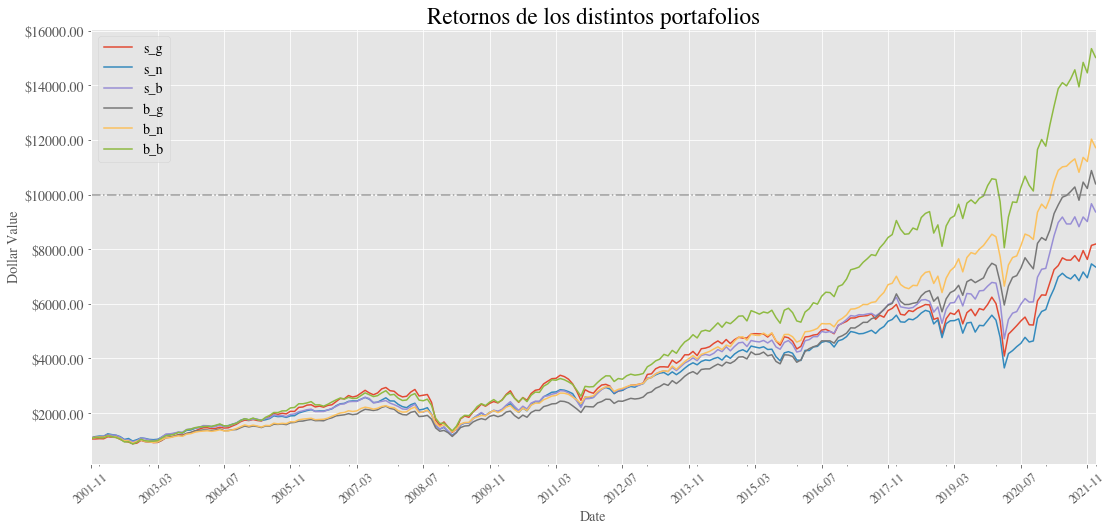

In [14]:
wealth_i = erk.wealth_index(ew_inds)

ax = wealth_i.plot(figsize =(18,8))
ax.set_title("Retornos de los distintos portafolios")
ax.set_ylabel("Dollar Value", size = 14)
ax.set_xlabel("Date", size = 14)
ax.yaxis.set_major_formatter('${x:1.2f}')
#ax.set_xticks(ticks = ports.index[::10], labels = ports.index[::10], size= 12, rotation = 45)
plt.xticks(ticks = ew_inds.index[::16], labels = ew_inds.index[::16], size= 12, rotation = 40)
ax.legend(prop ={"size" : 14}, loc = 2)
ax.axhline(y = 10000, color= "gray", alpha = .75, linestyle='-.')
plt.show()


In [15]:
#wealth_i.iloc['2001-10'] = 1000
#wealth_i.head()

In [16]:
#wealth_i.to_excel('thesis_ports.xlsx')

### Compute the actual factor timeseries
Following the F&F methodology we can compute the ling-short portfolio to hedge market risk ang get the factor time series. For this paper the factor is labeled BMG _Brown minus Green_. Were we are long on Brown assets and short on Green ones. This portfolios are an average of their small and big counterparts.

In [17]:
avgs = pd.DataFrame()

#ew_inds["green_avg"] = (ew_inds["s_g"]+ew_inds["b_g"])/2
#ew_inds["brown_avg"] = (ew_inds["s_b"]+ew_inds["b_b"])/2

avgs["green_avg"] = (ew_inds["s_g"]+ew_inds["b_g"])/2
avgs["brown_avg"] = (ew_inds["s_b"]+ew_inds["b_b"])/2

#avgs = ew_inds[["green_avg", "brown_avg"]].copy()
avgs["BMG"] = avgs["brown_avg"]-avgs["green_avg"]
avgs.head()

,green_avg,brown_avg,BMG
Date,,,
2001-11,0.080750,0.073552,-0.007199
2001-12,0.005437,0.044619,0.039182
2002-01,0.010891,-0.004233,-0.015124
2002-02,-0.001518,0.007141,0.008659
2002-03,0.059853,0.056268,-0.003585


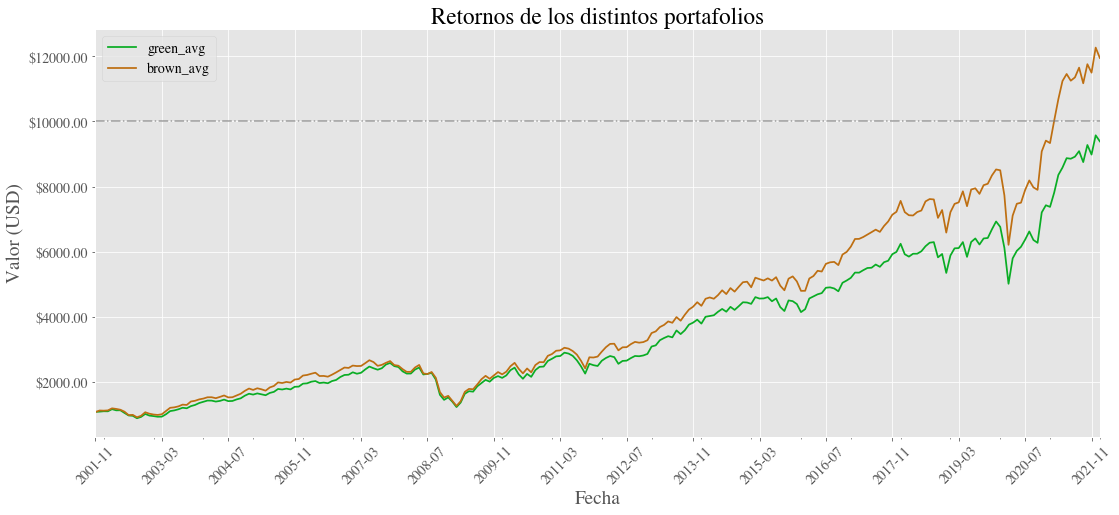

In [18]:
wealth_i2 = erk.wealth_index(avgs[['green_avg', 'brown_avg']])

ax = wealth_i2.plot(figsize =(18,7.5),title = "Retornos de Green y Brown portfolios",
                                     color = ["#0AAD25", "#BE6F12"],
                                    linewidth = 1.75)
ax.set_title("Retornos de los distintos portafolios")
ax.set_ylabel("Valor (USD)")
ax.set_xlabel("Fecha")
ax.yaxis.set_major_formatter('${x:1.2f}')
#plt.yticks(rotation = 45)
#ax.set_xticks(ticks = ports.index[::10], labels = ports.index[::10], size= 12, rotation = 45)
plt.xticks(ticks = ew_inds.index[::16], labels = ew_inds.index[::16], size= 14, rotation = 45)
ax.legend(prop ={"size" : 14}, loc = 2)
ax.axhline(y = 10000, color= "gray", alpha = .75, linestyle='-.')
plt.savefig(f'Graficas/Avgs_Ports.png',dpi = 300)
plt.show()


In [19]:
avgs.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 243 entries, 2001-11 to 2022-01
Freq: M
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   green_avg  243 non-null    float64
 1   brown_avg  243 non-null    float64
 2   BMG        243 non-null    float64
dtypes: float64(3)
memory usage: 7.6 KB


In [20]:
erk.summary_stats12(avgs, riskfree_rate= 0)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
green_avg,0.116942,0.170089,-0.511813,6.535620,0.073512,0.108186,0.687539,-0.524558
brown_avg,0.130329,0.170784,-0.467880,6.262136,0.072543,0.108645,0.763123,-0.526438
BMG,0.011523,0.036081,0.132049,3.412015,0.015608,0.019833,0.319366,-0.118860


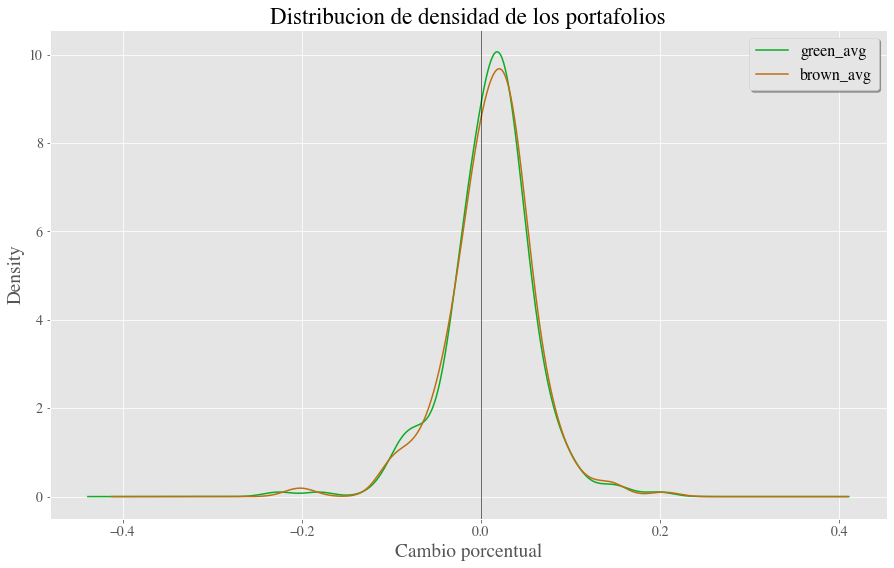

In [21]:
ax = avgs[["green_avg", "brown_avg"]].plot.density(figsize = (15,9), color = ["#0AAD25", "#BE6F12"], alpha = 1)
#
plt.title('Distribucion de densidad de los portafolios')
plt.xlabel('Cambio porcentual')
plt.legend(shadow = True)
plt.axvline(x = 0, color = 'black', linewidth= 0.75, alpha = .75)

plt.savefig(f'Graficas/Port_Dist.png',dpi = 300)
plt.show()

### Analizing the anualized returns and volatility
We can see that theres a premium for holding brown stocks over green ones, this is the reason that we substract the returns in this way.

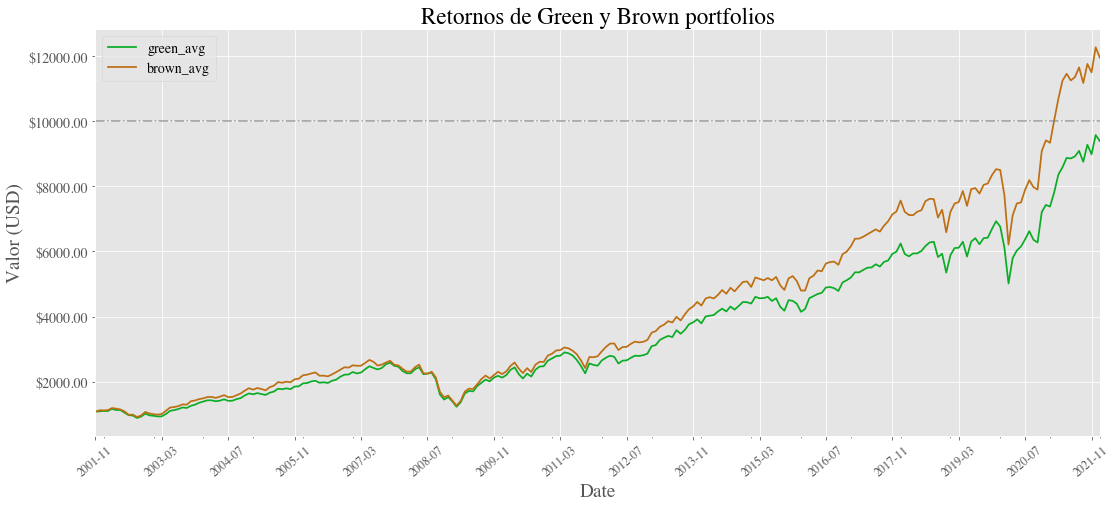

In [22]:
ax = erk.wealth_index(avgs[["green_avg", "brown_avg"]]).plot(figsize =(18,7.5), 
                                                        title = "Retornos de Green y Brown portfolios",
                                                       color = ["#0AAD25", "#BE6F12"],
                                                       linewidth = 1.75)
ax.set_ylabel("Valor (USD)")
ax.set_xlabel("Date")
ax.yaxis.set_major_formatter('${x:1.2f}')
#ax.set_xticks(ticks = ports.index[::10], labels = ports.index[::10], size= 12, rotation = 45)
plt.xticks(ticks = ew_inds.index[::16], labels = ew_inds.index[::16], size= 12, rotation = 40)
ax.legend(prop ={"size" : 14}, loc = 2)
ax.axhline(y = 10000, color= "gray", alpha = .75, linestyle='-.')
plt.show()



## *Now we start with the actual regressions*
- First loading the SPY monthly prices and obtaining their returns
- Fama and French factor returns are from Keneth French's online library

In [23]:
#importamos spy, hacemos retornos y ponemos fechas iguales en fff
spy = pd.read_excel("data/tesis/SPY.xlsx", index_col= "Date", parse_dates=["Date"]).to_period("M").sort_index(ascending=True).pct_change().dropna().loc['2001-11':"2021-12"]
#lol = pd.concat([voo, voo_m.loc['2010-10']], axis = 1)
spy.info(show_counts= True)

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 242 entries, 2001-11 to 2021-12
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     242 non-null    float64
dtypes: float64(1)
memory usage: 3.8 KB


In [24]:
spy.describe()

,SPY
count,242.000000
mean,0.007131
std,0.042374
min,-0.165187
25%,-0.016640
50%,0.012796
75%,0.031819
max,0.126984


In [25]:
m =spy.median()[0]
a = spy.mean()[0]
#mo = st.mode(spy['SPY'])
#mo

In [26]:
#spy.plot.density(figsize = (12,6))
#plt.title('Density distributions of SPY\'s returns')
#plt.axvline(x = a, color = 'blue', linestyle = ':')
#plt.axvline(x = m, color = 'green')
#plt.legend(shadow = True)
#plt.axvline(x = mo, color = 'black')
#plt.show()

In [27]:
fff = erk.get_fff_returns("Monthly").loc["2001-11":]
fff["BMG"] = np.round(avgs.loc[:"2021-12"].BMG.values, 4)

fff_spy = fff.loc['2001-11':'2021-12']
fff_spy.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 242 entries, 2001-11 to 2021-12
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  242 non-null    float64
 1   SMB     242 non-null    float64
 2   HML     242 non-null    float64
 3   RF      242 non-null    float64
 4   BMG     242 non-null    float64
dtypes: float64(5)
memory usage: 11.3 KB


In [28]:
#empezamos con la regresion 
exces_ret = pd.DataFrame(spy["SPY"] - fff_spy["RF"].values)
x_variabs = fff_spy[["Mkt-RF", "SMB", "HML", "BMG"]]
#x_variabs["constant"] = 1
x_variabs.columns = ["Mkt-RF", "Size", "Value", "Sus"]
#x_variabs["int"] = 1
x_variabs.head()

,Mkt-RF,Size,Value,Sus
Date,,,,
2001-11,0.0754,-0.0047,0.0222,-0.0072
2001-12,0.0160,0.0473,0.0085,0.0392
2002-01,-0.0144,0.0119,0.0344,-0.0151
2002-02,-0.0229,-0.0100,0.0216,0.0087
2002-03,0.0424,0.0421,0.0107,-0.0036


In [29]:
reg = sm.OLS(exces_ret, x_variabs).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    SPY   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              6778.
Date:                Mon, 25 Jul 2022   Prob (F-statistic):                   7.72e-244
Time:                        16:00:17   Log-Likelihood:                          993.00
No. Observations:                 242   AIC:                                     -1978.
Df Residuals:                     238   BIC:                                     -1964.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.9869      0.006    157.734      0.000       0.975       0.999
Size          -0.1626      0.011    -14.403      0.000      -0.185      -0.140
Value          0.0184      0.010      1.934      0.054      -0.000       0.037
Sus           -0.0217      0.025     -0.860      0.390      -0.071       0.028
==============================================================================
Omnibus:                        2.250   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.325   Jarque-Bera (JB):                2.102
Skew:                          -0.080   Prob(JB):                        0.350
Kurtosis:                       3.427   Cond. No.                         4.48
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
#empezamos con la regresion 
exces_ret = pd.DataFrame(spy["SPY"] - fff_spy["RF"].values)
x_variabs_bench = fff_spy[["Mkt-RF", "SMB", "HML"]]
#x_variabs["constant"] = 1
x_variabs_bench.columns = ["Mkt-RF", "Size", "Value"]
#x_variabs["int"] = 1
x_variabs_bench.head()

,Mkt-RF,Size,Value
Date,,,
2001-11,0.0754,-0.0047,0.0222
2001-12,0.0160,0.0473,0.0085
2002-01,-0.0144,0.0119,0.0344
2002-02,-0.0229,-0.0100,0.0216
2002-03,0.0424,0.0421,0.0107


In [31]:
reg_bench = sm.OLS(exces_ret, x_variabs_bench).fit()
reg_bench.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    SPY   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              9047.
Date:                Mon, 25 Jul 2022   Prob (F-statistic):                   1.08e-245
Time:                        16:00:17   Log-Likelihood:                          992.62
No. Observations:                 242   AIC:                                     -1979.
Df Residuals:                     239   BIC:                                     -1969.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.9871      0.006    158.026      0.000       0.975       0.999
Size          -0.1642      0.011    -14.751      0.000      -0.186      -0.142
Value          0.0177      0.009      1.868      0.063      -0.001       0.036
==============================================================================
Omnibus:                        2.475   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.290   Jarque-Bera (JB):                2.323
Skew:                          -0.107   Prob(JB):                        0.313
Kurtosis:                       3.430   Cond. No.                         2.02
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
esgu = pd.read_excel("data/tesis/ESGU.xlsx", index_col= "Date", parse_dates=["Date"]).to_period("M").pct_change().dropna().loc[:"2021-12"]
esgu.columns = ["ESGU"]

fff_esgu = fff.loc["2017-02":]
esgu.info(), fff_esgu.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 59 entries, 2017-02 to 2021-12
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ESGU    59 non-null     float64
dtypes: float64(1)
memory usage: 944.0 bytes
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 59 entries, 2017-02 to 2021-12
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  59 non-null     float64
 1   SMB     59 non-null     float64
 2   HML     59 non-null     float64
 3   RF      59 non-null     float64
 4   BMG     59 non-null     float64
dtypes: float64(5)
memory usage: 2.8 KB


(None, None)

In [33]:
esgu_ex_ret = pd.DataFrame(esgu["ESGU"] - fff_esgu["RF"].values)

esgu_reg = sm.OLS(esgu_ex_ret, x_variabs_bench.loc["2017-02":]).fit()
esgu_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   ESGU   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              2429.
Date:                Mon, 25 Jul 2022   Prob (F-statistic):                    3.07e-59
Time:                        16:00:17   Log-Likelihood:                          238.92
No. Observations:                  59   AIC:                                     -471.8
Df Residuals:                      56   BIC:                                     -465.6
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         1.0081      0.012     83.107      0.000       0.984       1.032
Size          -0.1526      0.022     -6.831      0.000      -0.197      -0.108
Value          0.0168      0.016      1.076      0.286      -0.014       0.048
==============================================================================
Omnibus:                        0.254   Durbin-Watson:                   2.456
Prob(Omnibus):                  0.881   Jarque-Bera (JB):                0.217
Skew:                           0.137   Prob(JB):                        0.897
Kurtosis:                       2.883   Cond. No.                         2.03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
esgu_ex_ret = pd.DataFrame(esgu["ESGU"] - fff_esgu["RF"].values)

esgu_reg = sm.OLS(esgu_ex_ret, x_variabs.loc["2017-02":]).fit()
esgu_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   ESGU   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              1809.
Date:                Mon, 25 Jul 2022   Prob (F-statistic):                    1.21e-57
Time:                        16:00:17   Log-Likelihood:                          239.25
No. Observations:                  59   AIC:                                     -470.5
Df Residuals:                      55   BIC:                                     -462.2
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         1.0085      0.012     82.769      0.000       0.984       1.033
Size          -0.1552      0.023     -6.849      0.000      -0.201      -0.110
Value          0.0174      0.016      1.108      0.273      -0.014       0.049
Sus           -0.0448      0.057     -0.784      0.436      -0.159       0.070
==============================================================================
Omnibus:                        0.122   Durbin-Watson:                   2.431
Prob(Omnibus):                  0.941   Jarque-Bera (JB):                0.170
Skew:                           0.099   Prob(JB):                        0.918
Kurtosis:                       2.827   Cond. No.                         5.08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
erk.summary_stats12(spy)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
SPY,0.077306,0.146789,-0.602703,4.45595,0.068139,0.097165,0.313478,-0.521953


In [36]:
spy.idxmin()

SPY    2008-10
dtype: period[M]

In [37]:
etfs_r = pd.DataFrame()
#etfs['200-10'] = 1000

etfs_r = pd.concat([spy['2017-02':],esgu], axis = 1)
erk.summary_stats12(etfs_r, riskfree_rate= 0)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
SPY,0.161468,0.156284,-0.612347,4.486430,0.066145,0.100832,1.033171,-0.199186
ESGU,0.186653,0.160257,-0.503815,4.583775,0.064911,0.100847,1.164716,-0.199080


In [38]:
etfs_r.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 59 entries, 2017-02 to 2021-12
Freq: M
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     59 non-null     float64
 1   ESGU    59 non-null     float64
dtypes: float64(2)
memory usage: 1.4 KB


<AxesSubplot:xlabel='Date'>

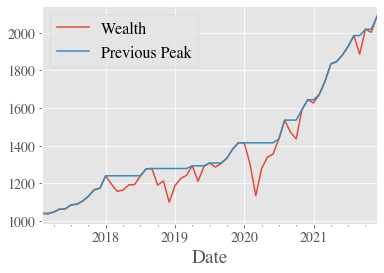

In [39]:
erk.drawdown(etfs_r['SPY'])[['Wealth', 'Previous Peak']].plot()

<AxesSubplot:xlabel='Date'>

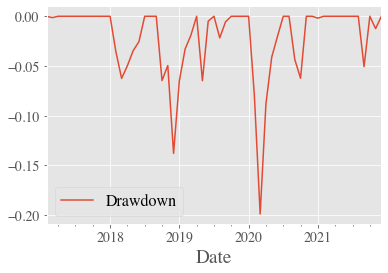

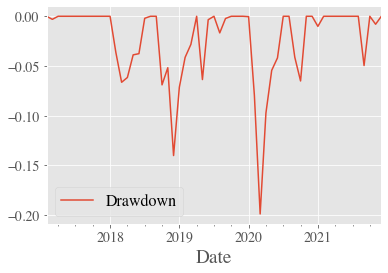

In [40]:
erk.drawdown(etfs_r['ESGU'])[['Drawdown']].plot()
erk.drawdown(etfs_r['SPY'])[['Drawdown']].plot()

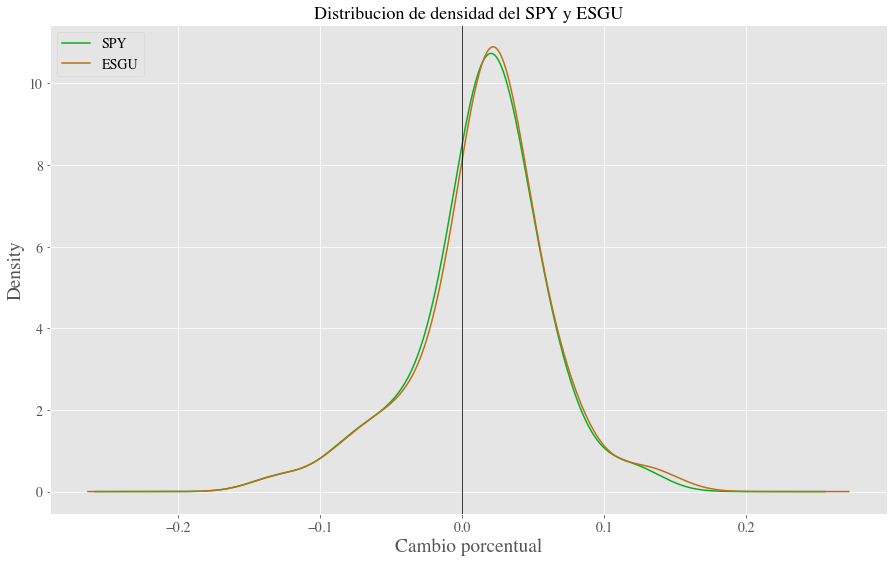

In [41]:
ax = etfs_r.plot.density(figsize = (15,9), color = ["#0AAD25", "#BE6F12"], alpha = 1)
plt.title('Distribucion de densidad del SPY y ESGU', size = 18)
plt.xlabel('Cambio porcentual')
plt.legend(shadow = True)
plt.axvline(x = 0, color = 'black', linewidth= 0.75)
ax.legend(prop ={"size" : 14}, loc = 2)
plt.savefig(f'Graficas/etfs_dist.png',dpi = 300)
plt.show()

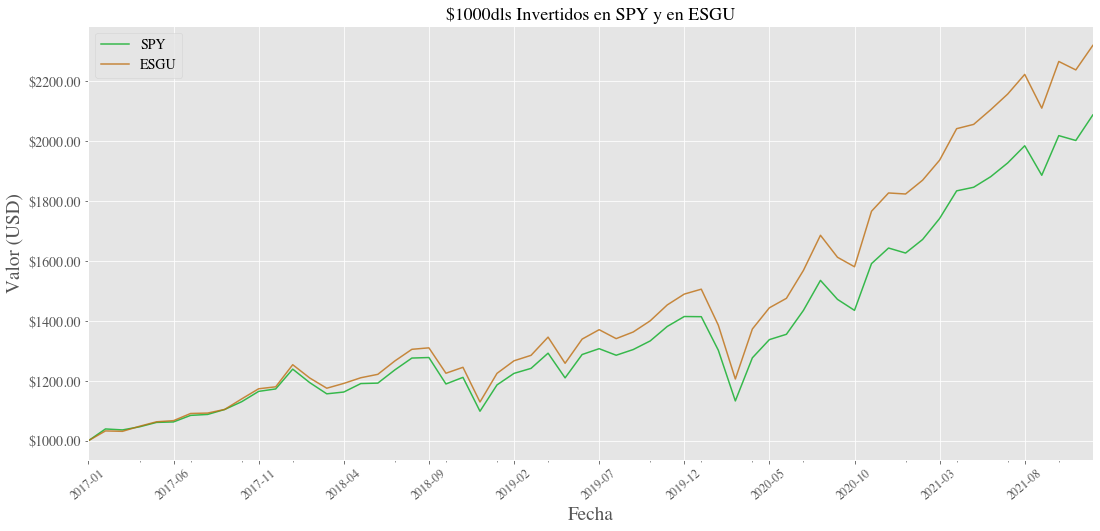

In [42]:
etfs_r.loc[pd.to_datetime('2017-01').to_period('M')] = 0
etfs_r.sort_index(ascending=True, inplace = True)
etfs_w = erk.wealth_index(etfs_r)

ax = etfs_w.plot(figsize = (18,8), color = ["#0AAD25", "#BE6F12"], alpha = 0.8)
ax.set_title('$1000dls Invertidos en SPY y en ESGU', size = 18)
plt.xticks(ticks = etfs_w.index[::5], 
           labels = etfs_w.index[::5], 
           size= 12, rotation = 40)
ax.set_ylabel("Valor (USD)")
ax.set_xlabel("Fecha")
ax.yaxis.set_major_formatter('${x:1.2f}')
ax.legend(prop ={"size" : 14}, loc = 2)
plt.savefig(f'Graficas/etfs_ret.png',dpi = 300)

plt.show()

<AxesSubplot:xlabel='Date'>

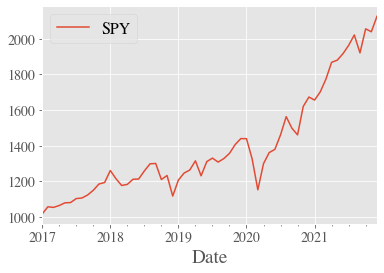

In [43]:
erk.wealth_index(spy.loc['2017-01':]).plot()

<AxesSubplot:xlabel='Date'>

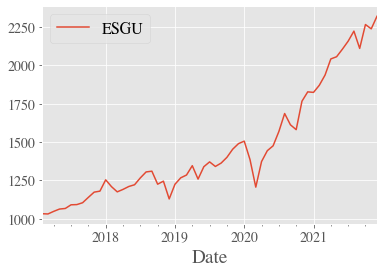

In [44]:
erk.wealth_index(esgu).plot()